In [1]:
% matplotlib inline
# % config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pickle

from limlam_mocker import limlam_mocker as llm
#Get Parameters for run
from limlam_mocker import params        as params

import lnn as lnn

%load_ext autoreload

In [2]:
%autoreload
# %autoreload 0
#%autoreload 2

# Setup Learning Enviornment

In [3]:
import tensorflow as tf
from tensorflow import keras

mapLoc = '../maps2/basic_Li/'
catLoc = '../catalogues2/'
modelLoc = '../models2/'

### map info
numb_maps = 100
pix_x = 256
pix_y = 256

### output info
lum_func_size = 49

In [4]:
### load in modules
from models_to_load import *

# Load Models

In [5]:
log_lum_5_layer_2D_more_filters = get_log_lum_5_layer_2D(modelLoc, pix_x, pix_y, numb_maps, lum_func_size, 
                                                         extra_file_name='_more_filters', filter_ratio=2)

# Visualization Functions

In [10]:
# get the symbolic outputs of each "key"
model = log_lum_5_layer_2D_more_filters
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [9]:
layer_dict

{'batch_normalization': <tensorflow.python.keras.layers.normalization.BatchNormalization at 0x7efe57a4d518>,
 'batch_normalization_1': <tensorflow.python.keras.layers.normalization.BatchNormalization at 0x7efe12f90198>,
 'batch_normalization_2': <tensorflow.python.keras.layers.normalization.BatchNormalization at 0x7efe12ef06a0>,
 'batch_normalization_3': <tensorflow.python.keras.layers.normalization.BatchNormalization at 0x7efe12e5be80>,
 'batch_normalization_4': <tensorflow.python.keras.layers.normalization.BatchNormalization at 0x7efe12d7ecc0>,
 'conv2d': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7efe13b2dcf8>,
 'conv2d_1': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7efe21e0b7f0>,
 'conv2d_2': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7efe13acc748>,
 'conv2d_3': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7efe12fb31d0>,
 'conv2d_4': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7efe13afa1d0>,
 'conv2d_5': <tenso

In [22]:
from keras import backend as K

layer_name = 'conv2d'
filter_index = 0

# build a loss function that maximizes the activation
# of the nth filter of the layer considered
layer_output = layer_dict[layer_name].output
loss = K.mean(layer_output[:, :, :, filter_index])

# compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, input_img)[0]

# normalization trick: we normalize the gradient
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

# this function returns the loss and grads given the input picture
iterate = K.function([input_img], [loss, grads])

ValueError: Tried to convert 'x' to a tensor and failed. Error: None values not supported.

In [20]:
img_width = 256
img_height = 256

# we start from a gray image with some noise
input_img_data = np.random.random((1, 3, img_width, img_height)) * 20 + 128.

# run gradient ascent for 20 steps
for i in range(20):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

NameError: name 'iterate' is not defined

In [21]:
img_width = 256
img_height = 256

# we start from a gray image with some noise
input_img_data = np.random.random((1, 3, img_width, img_height)) * 20 + 128.

In [30]:
import time
from tensorflow.keras import backend as K

In [37]:
# dimensions of the generated pictures for each filter.
img_width = 256
img_height = 256
img_depth = 100

layer_name = 'conv2d'
filter_index = 0

def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# get the symbolic outputs of each "key"
model = log_lum_5_layer_2D_more_filters
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# this is the placeholder for the input images
input_img = model.input

def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())

kept_filters = []
for filter_index in range(10):
    # we only scan through the first 200 filters,
    # but there are actually 512 of them
    print('Processing filter %d' % filter_index)
    start_time = time.time()

    # we build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
    if K.image_data_format() == 'channels_first':
        loss = K.mean(layer_output[:, filter_index, :, :])
    else:
        loss = K.mean(layer_output[:, :, :, filter_index])

    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # step size for gradient ascent
    step = 1.

    # we start from a gray image with some random noise
    if K.image_data_format() == 'channels_first':
        input_img_data = np.random.random((1, 3, img_width, img_height))
    else:
        input_img_data = np.random.random((1, img_width, img_height, 3))
    input_img_data = (input_img_data - 0.5) * 20 + 128
    
#     print(input_img_data[0][2])

    # we run gradient ascent for 20 steps
    for i in range(20):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

        print('Current loss value:', loss_value)
        if loss_value <= 0.:
            # some filters get stuck to 0, we can skip them
            break

    # decode the resulting input image
    if loss_value > 0:
        img = deprocess_image(input_img_data[0])
        kept_filters.append((img, loss_value))
    end_time = time.time()
    print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

Processing filter 0


InvalidArgumentError: input depth must be evenly divisible by filter depth: 3 vs 100
	 [[{{node conv2d/Conv2D}} = Conv2D[T=DT_FLOAT, _class=["loc:@gradients_10/conv2d/Conv2D_grad/Conv2DBackpropInput"], data_format="NHWC", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_conv2d_input_0_0, conv2d/Conv2D/ReadVariableOp)]]

In [50]:
input_img

<tf.Tensor 'conv2d_input:0' shape=(?, 256, 256, 100) dtype=float32>

In [39]:
from sklearn.utils import shuffle

model = log_lum_5_layer_2D_more_filters
layer_dict = dict([(layer.name, layer) for layer in model.layers])

input_img = model.layers[0].input

layer_names = ['conv2d', 'conv2d_2']
filter_index = 0

In [153]:
class VisualizeImageMaximizeFmap(object):
    def __init__(self,pic_shape):
        '''
        pic_shape : a dimention of a single picture e.g., (96,96,1)
        '''
        self.pic_shape = pic_shape
        
    def find_n_feature_map(self,layer_name,max_nfmap):
        '''
        shows the number of feature maps for this layer
        only works if the layer is CNN
        '''
        n_fmap = None
        for layer in model.layers:
            if layer.name == layer_name:
                weights = layer.get_weights()
                n_fmap=weights[1].shape[0]
        if n_fmap is None:
            print(layer_name + " is not one of the layer names..")
            n_fmap = 1
        n_fmap = np.min([max_nfmap,n_fmap])
        return(int(n_fmap))

    def find_image_maximizing_activation(self,iterate,input_img_data,
                                         picorig=False,
                                         n_iter = 30):
        '''
        The input image is scaled to range between 0 and 1
        picorig  : True  if the picture image for input is original scale
                         ranging between 0 and 225
                   False if the picture image for input is ranging [0,1]
        '''
            
        input_img_data = np.random.random((1, 
                                           self.pic_shape[0],
                                           self.pic_shape[1],
                                           self.pic_shape[2]))
        if picorig:
            ## if the original picture is unscaled and ranging between (0,225),
            ## then the image values are centered around 123 with STD=25
            input_img_data = input_img_data*25 + 123 
        ## I played with this step value but the final image looks to be robust
        step = 500 

        
        
        # gradient ascent
        loss_values = []
        for i in range(n_iter):
            
            loss_value, grads_value = iterate([input_img_data, 0])
            input_img_data += grads_value * step
            loss_values.append(loss_value) 
        return(input_img_data,loss_values)

    def create_iterate(self,input_img, layer_output,filter_index):
        '''
        layer_output[:,:,:,0] is (Nsample, 94, 94) tensor contains:
        W0^T [f(image)]_{i,j}], i = 1,..., 94, j = 1,..., 94
        
        layer_output[:,:,:,1] contains:
        W1^T [f(image)]_{i,j}], i = 1,..., 94, j = 1,..., 94
        
        W0 and W1 are different kernel!
        '''
        ## loss is a scalar 
        if len(layer_output.shape) == 4:
            ## conv layer 
            loss = K.mean(layer_output[:,  :, :, filter_index])
        elif len(layer_output.shape) ==2:
            ## fully connected layer
            loss = K.mean(layer_output[:, filter_index])
         
        # calculate the gradient of the loss evaluated at the provided image
        grads = K.gradients(loss, input_img)[0]
        # normalize the gradients
        grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

        # iterate is a function taking (input_img, scalar) and output [loss_value, gradient_value]
        iterate = K.function([input_img, K.learning_phase()], [loss, grads])
        return(iterate)

    def deprocess_image(self,x):
        # standardize to have a mean 0 and std  0.1 
        x -= x.mean()
        x /= (x.std() + 1e-5)
        x *= 0.1

        # Shift x to have a mean 0.5 and std 0.1
        # This means 95% of the x should be in between 0 and 1
        # if x is normal
        x += 0.5
        x = np.clip(x, 0, 1)

        # resclar the values to range between 0 and 255
        x *= 255
        x = np.clip(x, 0, 255).astype('uint8')

        return x

    def find_images(self,input_img,layer_names,layer_dict, max_nfmap,
                    picorig=False,n_iter=30):
        '''
        Input :

        input_img   : the alias of the input layer from the deep learning model
        layer_names : list containing the name of the layers whose feature maps to be used
        layer_dict  : symbolic outputs of each "key" layer (we gave them unique names).
        max_nfmap   : the maximum number of feature map to be used for each layer.
        pic_shape   : For example pic_shape = (96,96,1)

        Output : 
        dictionary 

        key = layer name 
        value = a list containing the tuple of (images, list of loss_values) that maximize each feature map
        '''
        argimage = {}
        ## Look for the image for each feature map of each layer one by one
        for layer_name in layer_names: ## the layer to visualize
            n_fmap = self.find_n_feature_map(layer_name,max_nfmap)
            layer_output = layer_dict[layer_name].output
            result = self.find_images_for_layer(input_img,
                                                layer_output,
                                                range(n_fmap),
                                                picorig=picorig,
                                                n_iter=n_iter)

            argimage[layer_name] = result
        return(argimage)

    def find_images_for_layer(self,input_img,layer_output,indecies,
                              picorig=False,n_iter=30):
        '''
        indecies : list containing index of 
                      --> filtermaps of CNN or 
                      --> nodes of fully-connected layer
        Output

        a list containing the tuple of (images, list of loss_values) 
        that maximize each feature map


        '''
        result_temp = []
        for filter_index in indecies: # filtermap to visualize
                print(filter_index)
                iterate = self.create_iterate(input_img, layer_output,filter_index)
                input_img_data, loss_values = self.find_image_maximizing_activation(
                    iterate,input_img,
                    picorig=picorig,
                    n_iter=n_iter)
                result_temp.append((input_img_data,loss_values))
        return(result_temp)

    def plot_images_wrapper(self,argimage,n_row = 8, scale = 1):
        '''
        scale : scale up or down the plot size
        '''
        pic_shape = self.pic_shape
        if pic_shape[2] == 1:
            pic_shape = self.pic_shape[:2]
        if len(argimage.keys()) < 2:
            layer_names = [list(argimage.keys())[0]]
        else:
            layer_names = np.sort(argimage.keys())


        for layer_name in layer_names:
            n_fmap = len(argimage[layer_name])
            n_col = np.ceil(n_fmap/float(n_row))
            fig = plt.figure(figsize=(n_col*scale,
                                      n_row*scale))
            fig.subplots_adjust(hspace=0.001,wspace=0.001)
            plt.title(layer_name + " n_featuremap=" + str(n_fmap))
            count = 1
            for value in argimage[layer_name]:
                input_img_data = value[0][0]
                img = self.deprocess_image(input_img_data)
                ax = fig.add_subplot(n_row,n_col,count,
                                    xticks=[],yticks=[])
                ax.imshow(img.reshape(*pic_shape)[:,:,0])#,cmap="gray")
                count += 1
            plt.show()

find images that maximize feature maps
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
plot them...


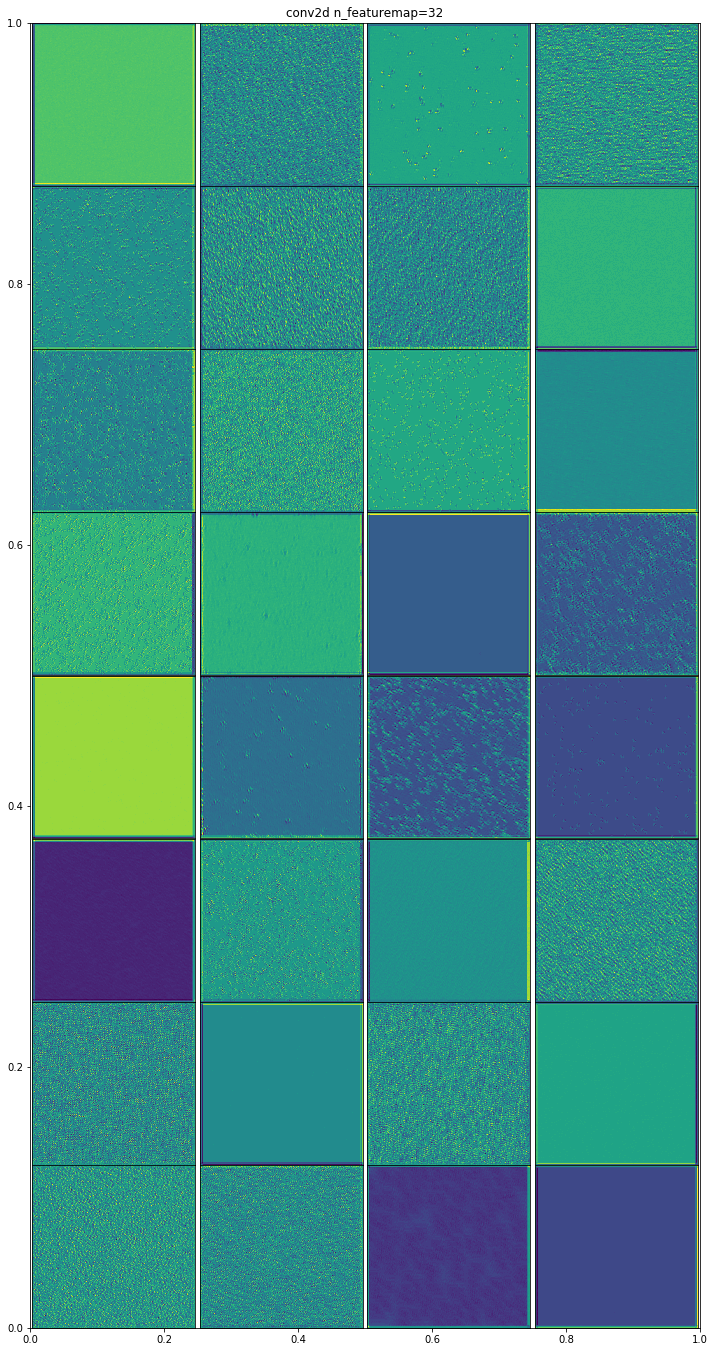

In [158]:
layer_names = ['conv2d']
max_nfmap = 32 #np.Inf ## print ALL the images

visualizer2 = VisualizeImageMaximizeFmap(pic_shape = (256,256,100))
print("find images that maximize feature maps")
argimage = visualizer.find_images(input_img,
                                  layer_names,
                                  layer_dict, 
                                  max_nfmap)
print("plot them...")
visualizer2.plot_images_wrapper(argimage,n_row = 8, scale = 3)

In [55]:
layer_names = ['conv2d']

plot them...


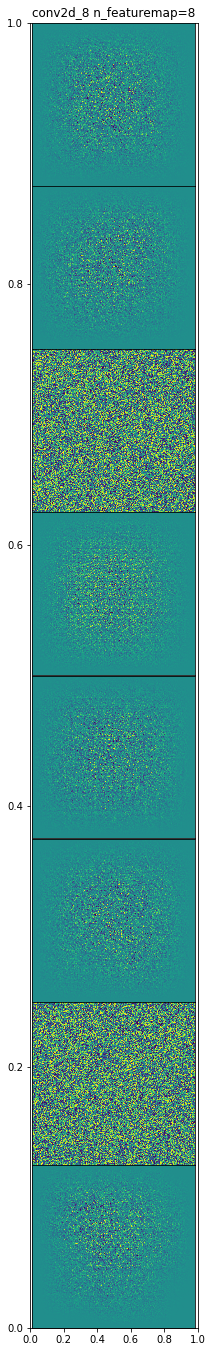

In [155]:
layer_names = ['conv2d_8']
max_nfmap = 8 #np.Inf ## print ALL the images

visualizer = VisualizeImageMaximizeFmap(pic_shape = (256,256,100))
print("find images that maximize feature maps")
argimage = visualizer.find_images(input_img,
                                  layer_names,
                                  layer_dict, 
                                  max_nfmap)
print("plot them...")
visualizer.plot_images_wrapper(argimage,n_row = 8, scale = 3)